<a href="https://colab.research.google.com/github/florencia-cicarone/tp3-HPC/blob/main/Cuaderno_2_%20Martes_%20grupo2_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introducción

En este cuaderno vamos a realizar el intercambio entre dos imágenes, es decir, reemplazaremos la imágen 1 por la imágen 2 y viceversa. Para esto utilizaremos una imagen auxiliar donde copiaremos la imagen 1 temporalmente. 
Los pasos que realizaremos serán los siguientes:
1.   Copiamos la imagen 1 a una imagen auxiliar
2.   Reemplazamos la imágen 1 por la 2
3.   Reemplazamos la imagen 2 por la imágen auxiliar

Para realizar estas acciones utilizaremos 2 funciones: kernel_img (para copiar la imágen 1 en la auxiliar) y copy_img (para el reemplazo de las imágenes)
    

# 2. Armado del ambiente


## 2.1 Imágenes

Tomamos la dirección web de dos imagenes con acceso público en internet, las dejamos disponibles al contexto de ejecución del cuaderno Colab.

In [ ]:
#@markdown ### Ingrese la dirección URL de la primer imágen
url_imagen1 = "https://fondosmil.com/fondo/11789.jpg" #@param {type:"string"}

#@markdown ---
#@markdown ### Ingrese la dirección URL de la segunda imágen
url_imagen2 = "https://fondosmil.com/fondo/67878.jpg" #@param {type:"string"}
#url_imagen2 = "https://s11.favim.com/orig/7/759/7598/75985/pink-aesthetic-sunglasses-Favim.com-7598576.jpg" #@param {type:"string"}


#Leo las imagenes desde internet.
!wget {url_imagen1} -O imagen1.jpg
!wget {url_imagen2} -O imagen2.jpg

--2021-07-04 19:14:33--  https://fondosmil.com/fondo/11789.jpg
Resolving fondosmil.com (fondosmil.com)... 107.150.40.186
Connecting to fondosmil.com (fondosmil.com)|107.150.40.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328865 (321K) [image/jpeg]
Saving to: ‘imagen1.jpg’

imagen1.jpg         100%[===================>] 321.16K  1.07MB/s    in 0.3s    

2021-07-04 19:14:34 (1.07 MB/s) - ‘imagen1.jpg’ saved [328865/328865]

--2021-07-04 19:14:34--  https://fondosmil.com/fondo/67878.jpg
Resolving fondosmil.com (fondosmil.com)... 107.150.40.186
Connecting to fondosmil.com (fondosmil.com)|107.150.40.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 369162 (361K) [image/jpeg]
Saving to: ‘imagen2.jpg’

imagen2.jpg         100%[===================>] 360.51K   965KB/s    in 0.4s    

2021-07-04 19:14:35 (965 KB/s) - ‘imagen2.jpg’ saved [369162/369162]



## 2.2 Módulo CUDA

Se instala en el cuaderno el módulo CUDA de python.

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 7.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=7192d928374a48fc3ac8158af286d4de44c690be634be326f8752d976fa8c080
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=639fa31daf51ffb54ca944a061832dbe80b72a940f4341441d7ff265fa0273d7
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


# 3. Desarrollo CPU

Ejecución del algoritmo adición de dos imágenes en CPU.





Imagen1: imagen1.jpg -RGB- [1920, 1080]
Imagen2: imagen2.jpg -RGB- [1080, 1920]
Imagen1: imagen1.jpg -RGB- [1080, 1920]
Imagen2: imagen2.jpg -RGB- [1920, 1080]
Tiempo de conversión de imagen: 10922.098 [ms]
Tiempo Total: 11159.653 [ms]


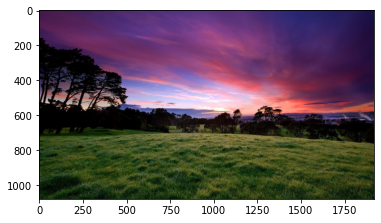

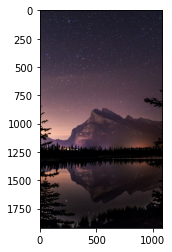

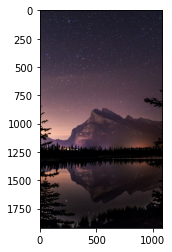

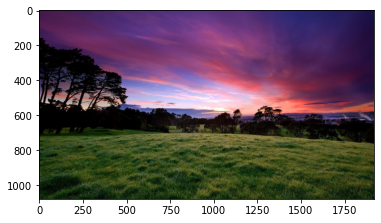

In [ ]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

try:
  img1_nombre = 'imagen1.jpg'
  image1 = Image.open( img1_nombre ) 
except:
  raise Exception("No se pudo abrir la imagen 1")

try:
  img2_nombre = 'imagen2.jpg'
  image2 = Image.open( img2_nombre ) 
except:
  raise Exception("No se pudo abrir la imagen 2")

# Optengo las proporsiones de la imagen. 
img1_ancho, img1_alto = image1.size 
img2_ancho, img2_alto = image2.size 

# Optengo la proporsion de la imagen 1
imagenAux_alto, imagenAux_ancho = image1.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img1_pic_cpu = numpy.asarray(image1)
img1_pic_cpu = img1_pic_cpu.astype(numpy.int32())
img2_pic_cpu = numpy.asarray(image2)
img2_pic_cpu = img2_pic_cpu.astype(numpy.int32())

# Genero el array auxiliar (3 pixeles usa RGB * (el tamaño del array)).
imgAux_picR_cpu = numpy.empty_like(img1_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes de la adición.
print("Imagen1: " + img1_nombre + " -" + image1.mode + "- [" + str(img1_ancho) + ", " + str(img1_alto ) + "]" )  
plt.figure()
imgplot1=plt.imshow( img1_pic_cpu )

print("Imagen2: " + img2_nombre + " -" + image2.mode + "- [" + str(img2_ancho) + ", " + str(img2_alto ) + "]" )  
plt.figure()
imgplot2=plt.imshow( img2_pic_cpu )

tiempo_img = datetime.now()

# Copio La imágen 1 a una imagen auxiliar
for y  in range( 0, imagenAux_alto ):
  for x in range( 0, imagenAux_ancho ):
    pixel_R1, pixel_G1, pixel_B1 = img1_pic_cpu[x][y]
    R = pixel_R1
    G = pixel_G1
    B = pixel_B1
    imgAux_picR_cpu[x][y] = [R, G, B]

# Redimenciono la imagen 1 
image1 = image1.resize((img2_ancho,img2_alto))
img1_pic_cpu = numpy.asarray(image1)
img1_pic_cpu = img1_pic_cpu.astype(numpy.int32())

#Copio la imagen 2 en la 1
for y  in range( 0, img2_ancho ):
  for x in range( 0, img2_alto ):
    img1_pic_cpu[x][y] = img2_pic_cpu[x][y]

#Redirecciono la imagen 2
image2 = image2.resize((img1_ancho,img1_alto))
img2_pic_cpu = numpy.asarray(image2)
img2_pic_cpu = img2_pic_cpu.astype(numpy.int32())

#Copio la imagen auxiliar en la imagen 2
for y  in range( 0, imagenAux_alto ):
  for x in range( 0, imagenAux_ancho ):
    img2_pic_cpu[x][y] = imgAux_picR_cpu[x][y]

tiempo_img = datetime.now() - tiempo_img

#Obtengo las nuevas dimenciones
img1_ancho, img1_alto = image1.size 
img2_ancho, img2_alto = image2.size 

# Muestro las imágenes luego de invertirlas.
print("Imagen1: " + img1_nombre + " -" + image1.mode + "- [" + str(img1_ancho) + ", " + str(img1_alto ) + "]" )  
plt.figure()
imgplot1=plt.imshow( img1_pic_cpu )

print("Imagen2: " + img2_nombre + " -" + image2.mode + "- [" + str(img2_ancho) + ", " + str(img2_alto ) + "]" )  
plt.figure()
imgplot2=plt.imshow( img2_pic_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

# 4. Desarrollo GPU

Ejecución del algoritmo adición de dos imágenes en GPU.


Imagen1: imagen1.jpg -RGB- [1920, 1080]
Imagen2: imagen2.jpg -RGB- [1080, 1920]
Thread: [ 16 , 19  ], Bloque : [ 120 , 57 ]
Total de Thread: [ 1920 , 1083  ]  =  2079360
Imagen1: imagen1.jpg -RGB- [1080, 1920]
Imagen2: imagen2.jpg -RGB- [1920, 1080]
Tiempo TOTAL:  355.068 [ms]
Tiempo GPU  :  81.48 [ms]


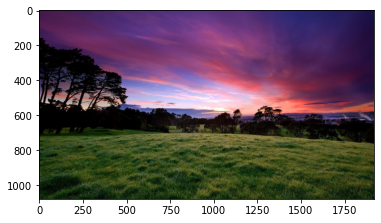

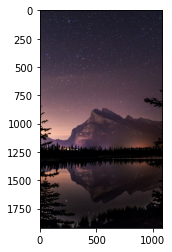

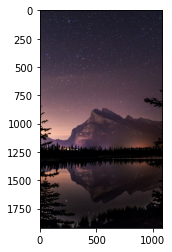

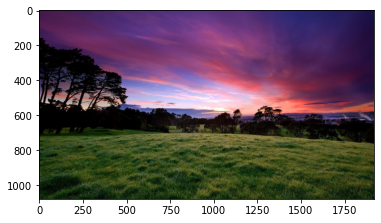

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


try:
  img1_nombre = 'imagen1.jpg'
  image1 = Image.open( img1_nombre ) 
except:
  raise Exception("No se pudo abrir la imagen 1")

try:
  img2_nombre = 'imagen2.jpg'
  image2 = Image.open( img2_nombre ) 
except:
  raise Exception("No se pudo abrir la imagen 2")

# Optengo las proporsiones de la imagen. 
img1_ancho, img1_alto = image1.size 
img2_ancho, img2_alto = image2.size 

# Determino la proporcion de la imágen Aux en relación a la imágen 1
imagenAux_ancho, imagenAux_alto = image1.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img1_pic_cpu = numpy.asarray(image1)
img1_pic_cpu = img1_pic_cpu.astype(numpy.int32())
img2_pic_cpu = numpy.asarray(image2)
img2_pic_cpu = img2_pic_cpu.astype(numpy.int32())

# Genero el array auxiliar (3 pixeles usa RGB * (el tamaño del array)).
imgAux_picR_cpu = numpy.empty_like(img1_pic_cpu)

# Reservos los 3 vectores en GPU (3 pixeles usa RGB * el tamaño del array)
img1_pic_gpu = cuda.mem_alloc( img1_pic_cpu.nbytes)
img2_pic_gpu = cuda.mem_alloc( img2_pic_cpu.nbytes)
imgAux_picR_gpu = cuda.mem_alloc( imgAux_picR_cpu.nbytes)

# GPU - Copio la memoria al GPU
cuda.memcpy_htod( img1_pic_gpu, img1_pic_cpu )
cuda.memcpy_htod( img2_pic_gpu, img2_pic_cpu )
cuda.memcpy_htod( imgAux_picR_gpu, imgAux_picR_cpu )

#CPU - Defino la función kernel que ejecutará en GPU
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img1, int *img2, int *imgRes )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fR = 0.0;
  float fG = 0.0;
  float fB = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    fR = (float)(img1[(idx+(idy*ancho))*3]);  // Componente Rojo del pixel.
    fG =(float)(img1[((idx+(idy*ancho))*3)+1]);  // Componente Verde del pixel.
    fB =(float)(img1[((idx+(idy*ancho))*3)+2]);   // Componente Azul del pixel. 

    // Escribo el color del pixel.
    imgRes[(idx+(idy*ancho))*3  ] = (int) fR;
    imgRes[(idx+(idy*ancho))*3+1] = (int) fG;
    imgRes[(idx+(idy*ancho))*3+2] = (int) fB;
  }
}
__global__ void kernel_copy( int ancho, int alto, int *img1, int *img2)
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fR = 0.0;
  float fG = 0.0;
  float fB = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    fR = (float)(img2[(idx+(idy*ancho))*3]);  // Componente Rojo del pixel.
    fG =(float)(img2[((idx+(idy*ancho))*3)+1]);  // Componente Verde del pixel.
    fB =(float)(img2[((idx+(idy*ancho))*3)+2]);   // Componente Azul del pixel. 

    // Escribo el color del pixel.
    img1[(idx+(idy*ancho))*3  ] = (int) fR;
    img1[(idx+(idy*ancho))*3+1] = (int) fG;
    img1[(idx+(idy*ancho))*3+2] = (int) fB;
  }
}

""")

# Muestro los atributos de la imagen y como se ve antes de la adición.
print("Imagen1: " + img1_nombre + " -" + image1.mode + "- [" + str(img1_ancho) + ", " + str(img1_alto ) + "]" )  
plt.figure()
imgplot1=plt.imshow( img1_pic_cpu )

print("Imagen2: " + img2_nombre + " -" + image2.mode + "- [" + str(img2_ancho) + ", " + str(img2_alto ) + "]" )  
plt.figure()
imgplot2=plt.imshow( img2_pic_cpu )



#CPU - Genero la función kernel.
kernel =  module.get_function("kernel_img")
copy = module.get_function("kernel_copy")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (imagenAux_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (imagenAux_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()
#LLamo a la función kernel
kernel( numpy.int32(imagenAux_ancho), numpy.int32(imagenAux_alto), img1_pic_gpu, img2_pic_gpu, imgAux_picR_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

#Redimenciono la imágen 1 y copio la imágen 2
image1 = image2.resize((img2_ancho,img2_alto))
img1_pic_cpu = numpy.asarray(image1)
img1_pic_cpu = img1_pic_cpu.astype(numpy.int32())
copy( numpy.int32(img2_alto) ,numpy.int32(img2_ancho), img1_pic_gpu, img2_pic_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1))

#Redimenciono la imágen 2 y copio la imágen auxiliar
image2 = image1.resize((img1_ancho,img1_alto))
img2_pic_cpu = numpy.asarray(image2)
img2_pic_cpu = img2_pic_cpu.astype(numpy.int32())
copy( numpy.int32(img1_ancho), numpy.int32(img1_alto), img2_pic_gpu, imgAux_picR_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1))

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img1_pic_cpu, img1_pic_gpu )
cuda.memcpy_dtoh( img2_pic_cpu, img2_pic_gpu )

# Muestro las imagenes invertidas.
img1_ancho, img1_alto = image1.size 
img2_ancho, img2_alto = image2.size 

print("Imagen1: " + img1_nombre + " -" + image1.mode + "- [" + str(img1_ancho) + ", " + str(img1_alto ) + "]" )  
plt.figure()
imgplot1=plt.imshow( img1_pic_cpu )

print("Imagen2: " + img2_nombre + " -" + image2.mode + "- [" + str(img2_ancho) + ", " + str(img2_alto ) + "]" )  
plt.figure()
imgplot2=plt.imshow( img2_pic_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

# 5. Métricas

Comparativa de las velocidades entre CPU y GPU


|                                   | CPU            | GPU           |
|-----------------------------------|----------------|---------------|
|**Tiempo de conversión de imagen:**| 10922.098 [ms] | 83.607 [ms]   |
|**Tiempo TOTAL:**                  | 11159.653 [ms] | 113.482 [ms]  |


# 6. Conclusiones

Como vimos, en comparación con la CPU, la GPU es un procesador formado por muchos núcleos más pequeños y especializados. Al trabajar conjuntamente, los núcleos ofrecen un desempeño masivo cuando se puede dividir una tarea de procesamiento y es procesada por muchos núcleos. En los Ejercicios presentados se puede ver claramente una mejora en el rendimiento al utilizar GPU, observando en la comparativa de velocidades tiempos hasta 10 veces menores.


# 7. Bibliografía



*   https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb
*  https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/google_colab_tutorial.pdf

